<a href="https://colab.research.google.com/github/mannat244/ML_Lab/blob/main/HingBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets pandas scikit-learn accelerate torch


✅ File loaded successfully!

🔍 --- 1. MISSING VALUES ---
Date            50
User            50
Unnamed: 3    4050
dtype: int64

🔍 --- 2. DUPLICATES ---
Found 329 duplicate tweets.

🔍 --- 3. CLASS DISTRIBUTION (Corrected_Sentiment) ---
Corrected_Sentiment
Positive    1624
Neutral     1458
Negative     968
Name: count, dtype: int64


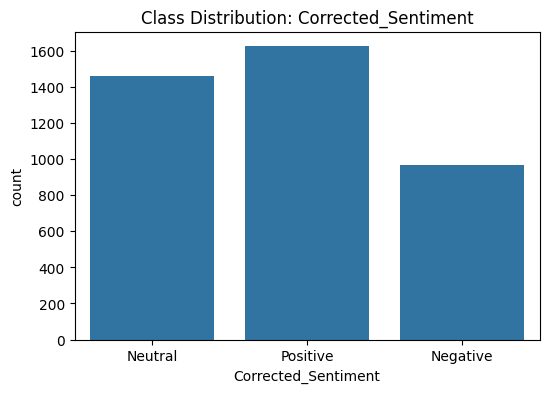


🔍 --- 4. TEXT LENGTH ANALYSIS ---
count    4050.000000
mean       33.299259
std        11.686606
min         4.000000
25%        25.000000
50%        34.500000
75%        42.000000
max       102.000000
Name: word_count, dtype: float64

Tweets with < 3 words: 0


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data (Adjust path if needed)
file_path = '/content/sample_data/master_stance_sentiment.csv'

try:
    df = pd.read_csv(file_path)
    print("✅ File loaded successfully!")
except FileNotFoundError:
    print(f"❌ File not found at {file_path}. Please check the path.")
    # Stop execution if file not found (in a real script)

# --- CHECK 1: MISSING VALUES ---
print("\n🔍 --- 1. MISSING VALUES ---")
missing = df.isnull().sum()
print(missing[missing > 0])
# Recommendation: If 'Tweet' or target column has nulls, drop those rows.

# --- CHECK 2: DUPLICATES ---
print("\n🔍 --- 2. DUPLICATES ---")
# Check for exact duplicate tweets (common in Twitter data due to RTs/bots)
duplicates = df[df.duplicated(subset=['Tweet'], keep=False)]
num_duplicates = df.duplicated(subset=['Tweet']).sum()
print(f"Found {num_duplicates} duplicate tweets.")
# Recommendation: Drop duplicates to prevent data leakage between train/test sets.

# --- CHECK 3: CLASS IMBALANCE ---
target_col = 'Corrected_Sentiment'  # Change to 'Stance_BJP' if that's your target
print(f"\n🔍 --- 3. CLASS DISTRIBUTION ({target_col}) ---")
print(df[target_col].value_counts())
# Visual check
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title(f'Class Distribution: {target_col}')
plt.show()
# Recommendation: If one class is <10% of the data, use class weights.

# --- CHECK 4: TEXT LENGTH ---
print("\n🔍 --- 4. TEXT LENGTH ANALYSIS ---")
# Estimate word count
df['word_count'] = df['Tweet'].astype(str).apply(lambda x: len(x.split()))
print(df['word_count'].describe())

# Check for extremely short tweets (garbage)
short_tweets = df[df['word_count'] < 3]
print(f"\nTweets with < 3 words: {len(short_tweets)}")
# Recommendation: Inspect these. They might be just emojis or single words like "Yes".

In [3]:
# --- CLEANING BLOCK ---

# 1. Remove the empty 'Unnamed: 3' column
if 'Unnamed: 3' in df.columns:
    df = df.drop(columns=['Unnamed: 3'])
    print("✅ Dropped empty 'Unnamed: 3' column.")

# 2. Drop Duplicate Tweets
# We keep the 'first' occurrence and drop the rest to avoid data leakage
initial_count = len(df)
df = df.drop_duplicates(subset=['Tweet'], keep='first')
dropped_count = initial_count - len(df)
print(f"✅ Dropped {dropped_count} duplicate tweets.")

# 3. Handle Missing Values
# We do NOT drop rows where Date/User are missing because the 'Tweet' and 'Label'
# are likely still valid. We only drop if Tweet or Target is missing.
df = df.dropna(subset=['Tweet', 'Corrected_Sentiment'])

# 4. Reset Index
# Important for PyTorch/Hugging Face datasets to access rows by index correctly
df = df.reset_index(drop=True)

print("\n--- Final Data Stats ---")
print(f"Original Row Count: {initial_count}")
print(f"Cleaned Row Count:  {len(df)}")
print("\nNew Class Distribution:")
print(df['Corrected_Sentiment'].value_counts())

# Check a random row to ensure it looks good
print("\nSample Cleaned Row:")
print(df.sample(1)[['Tweet', 'Corrected_Sentiment']].to_dict('records'))

✅ Dropped empty 'Unnamed: 3' column.
✅ Dropped 329 duplicate tweets.

--- Final Data Stats ---
Original Row Count: 4050
Cleaned Row Count:  3721

New Class Distribution:
Corrected_Sentiment
Positive    1527
Neutral     1323
Negative     871
Name: count, dtype: int64

Sample Cleaned Row:
[{'Tweet': 'Countdown to #May23: Both Narendra Modi of #BJP and Rahul Gandhi of #Congress are upbeat about becoming the prime minister. What if there’s a dark horse quietly waiting to be sworn in after votes are declared after this #LokSabhaEelctions2019', 'Corrected_Sentiment': 'Neutral'}]


In [7]:
from transformers import pipeline

# 1. Load the trained model from the local folder
model_path = "./final_hing_roberta_model"

print("Loading model for testing...")
# We use the 'text-classification' pipeline which makes it super easy
classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)

# 2. Define your custom Hinglish inputs
custom_tweets = [
    "Modi ji ne desh ka naam roshan kiya hai! Proud of India.",   # Positive example
    "Mehngai ne aam aadmi ki kamar tod di hai. Govt fail hai.",   # Negative example
    "Election aa rahe hain, dekhte hain kya hota hai.",            # Neutral example
    "Rahul Gandhi ka speech acha tha par voting BJP ko hi dunga."  # Mixed/Complex
]

# 3. Run predictions
print("\n--- 🔍 Prediction Results ---")
for tweet in custom_tweets:
    result = classifier(tweet)[0]
    label = result['label']
    score = result['score']

    print(f"Tweet: '{tweet}'")
    print(f"Pred : {label} ({score:.4f})\n")

# 4. Interactive Mode (Optional)
# Uncomment the lines below to type your own tweets live!
# while True:
#     user_input = input("Enter a tweet (or 'q' to quit): ")
#     if user_input.lower() == 'q': break
#     print(classifier(user_input))

Loading model for testing...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


--- 🔍 Prediction Results ---
Tweet: 'Modi ji ne desh ka naam roshan kiya hai! Proud of India.'
Pred : Positive (0.8895)

Tweet: 'Mehngai ne aam aadmi ki kamar tod di hai. Govt fail hai.'
Pred : Negative (0.8382)

Tweet: 'Election aa rahe hain, dekhte hain kya hota hai.'
Pred : Neutral (0.4069)

Tweet: 'Rahul Gandhi ka speech acha tha par voting BJP ko hi dunga.'
Pred : Positive (0.6197)



In [5]:
# 1. Install necessary libraries (Run this line once if not installed)
# !pip install transformers datasets pandas scikit-learn accelerate torch

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import os

# --- Configuration ---
MODEL_NAME = "l3cube-pune/hing-roberta"
TARGET_COLUMN = "Corrected_Sentiment"
FILE_NAME = "/content/sample_data/master_stance_sentiment.csv"

# --- 1. Data Preparation ---
print(f"Loading data from {FILE_NAME}...")

if os.path.exists(FILE_NAME):
    df = pd.read_csv(FILE_NAME)
else:
    # Fallback if running locally
    df = pd.read_csv("master_stance_sentiment.csv")

# --- CLEANING & EDA BLOCK ---
# 1. Remove 'Unnamed: 3' if exists
if 'Unnamed: 3' in df.columns:
    df = df.drop(columns=['Unnamed: 3'])

# 2. Drop Duplicate Tweets
df = df.drop_duplicates(subset=['Tweet'], keep='first')

# 3. Handle Missing Values
df = df.dropna(subset=['Tweet', TARGET_COLUMN])

# 4. Reset Index
df = df.reset_index(drop=True)

print(f"Cleaned Row Count:  {len(df)}")
# --- END CLEANING BLOCK ---

# Ensure text is string
df['Tweet'] = df['Tweet'].astype(str)

# Encode Labels
label_list = df[TARGET_COLUMN].unique().tolist()
label_list.sort()
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
print(f"Detected Labels: {label2id}")

df['labels'] = df[TARGET_COLUMN].map(label2id)

# Split data
train_df, eval_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['labels']
)

# Convert to Dataset
train_dataset = Dataset.from_pandas(train_df[['Tweet', 'labels']])
eval_dataset = Dataset.from_pandas(eval_df[['Tweet', 'labels']])

# --- 2. Tokenization ---
print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["Tweet"], padding="max_length", truncation=True, max_length=128)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
eval_tokenized = eval_dataset.map(tokenize_function, batched=True)

# --- 3. Metrics Function ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- 4. Model Setup ---
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# --- 5. Training Arguments (FIXED HERE) ---
training_args = TrainingArguments(
    output_dir="./hing_roberta_results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",  # <--- CHANGED FROM evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=2e-5,
)

# --- 6. Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    compute_metrics=compute_metrics,
)

# --- 7. Train & Evaluate ---
print("Starting training with Hing-RoBERTa...")
trainer.train()

print("Evaluating...")
eval_results = trainer.evaluate()
print(f"Final Evaluation Results: {eval_results}")

# --- 8. Save Model ---
trainer.save_model("./final_hing_roberta_model")
tokenizer.save_pretrained("./final_hing_roberta_model")
print("Model saved successfully!")

Loading data from /content/sample_data/master_stance_sentiment.csv...
Cleaned Row Count:  3721
Detected Labels: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
Loading tokenizer for l3cube-pune/hing-roberta...


Map:   0%|          | 0/2976 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: l3cube-pune/hing-roberta
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` ins

Starting training with Hing-RoBERTa...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.066753,1.011490,0.459060,0.359152,0.411991,0.459060
2,0.798814,0.795616,0.668456,0.668748,0.677478,0.668456
3,0.661161,0.842671,0.672483,0.670695,0.697104,0.672483
4,0.470522,0.713569,0.753020,0.752468,0.756521,0.753020


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Evaluating...


Final Evaluation Results: {'eval_loss': 0.7135692834854126, 'eval_accuracy': 0.7530201342281879, 'eval_f1': 0.7524678305607715, 'eval_precision': 0.756521069771307, 'eval_recall': 0.7530201342281879, 'eval_runtime': 6.2709, 'eval_samples_per_second': 118.802, 'eval_steps_per_second': 7.495, 'epoch': 4.0}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved successfully!


In [8]:
import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm
import os

# --- CONFIGURATION ---
FILES = ['export.csv', 'export2.csv']
MODEL_PATH = "./final_hing_roberta_model"

# --- 1. LOAD & CLEAN ---
print("📂 Loading and Cleaning Data...")
clean_dfs = []

for filename in FILES:
    if os.path.exists(filename):
        try:
            # on_bad_lines='skip' helps if the CSV has formatting errors
            df = pd.read_csv(filename, on_bad_lines='skip')

            # 1. DROP UNNECESSARY COLUMNS (Video/Image)
            # We drop anything that looks like an image or video column
            drop_cols = [c for c in df.columns if 'video' in c.lower() or 'image' in c.lower() or 'thumbnail' in c.lower()]
            if drop_cols:
                df = df.drop(columns=drop_cols)
                print(f"   ✂️  Dropped unnecessary columns in {filename}: {drop_cols}")

            # 2. RENAME CONTENT -> TWEET
            # The model expects 'Tweet', so we standardize the name
            if 'Content' in df.columns:
                df = df.rename(columns={'Content': 'Tweet'})

            # 3. FILTER
            # Keep only the Tweet column and maybe Date/Stats for context
            # We force it to have a 'Tweet' column
            if 'Tweet' in df.columns:
                df = df.dropna(subset=['Tweet']) # Drop empty rows
                df['Source_File'] = filename     # Track where it came from
                clean_dfs.append(df)
            else:
                print(f"   ⚠️  Skipping {filename}: Could not find 'Content' or 'Tweet' column.")

        except Exception as e:
            print(f"   ❌ Error reading {filename}: {e}")

if not clean_dfs:
    print("\n❌ No valid data found to process.")
else:
    # Combine all cleaned files
    full_df = pd.concat(clean_dfs, ignore_index=True)

    # Final Deduplication
    full_df = full_df.drop_duplicates(subset=['Tweet'], keep='first')

    print(f"\n✅ Data Ready! Total Unique Tweets: {len(full_df)}")
    print(f"   Columns: {list(full_df.columns)}")

    # --- 2. RUN MODEL (INFERENCE) ---
    print("\n🤖 Running Model Predictions...")

    if os.path.exists(MODEL_PATH):
        try:
            # Load Model
            classifier = pipeline("text-classification", model=MODEL_PATH, tokenizer=MODEL_PATH, truncation=True, max_length=128)

            # Run Predictions
            # We use a batch process for speed
            results = classifier(full_df['Tweet'].tolist())

            # Add results to DataFrame
            full_df['Predicted_Sentiment'] = [r['label'] for r in results]
            full_df['Confidence'] = [r['score'] for r in results]

            # --- 3. SAVE OUTPUT ---
            output_file = "Final_Sentiment_Analysis.csv"
            full_df.to_csv(output_file, index=False)

            print(f"\n🎉 Success! Output saved to: {output_file}")
            print("\nSample Results:")
            print(full_df[['Tweet', 'Predicted_Sentiment', 'Confidence']].head())

        except Exception as e:
            print(f"\n❌ Error running model: {e}")
            print("Did you run the Training Block? The model folder must exist.")
    else:
        print(f"\n❌ Model not found at {MODEL_PATH}. Please run the Training Block first.")

📂 Loading and Cleaning Data...
   ✂️  Dropped unnecessary columns in export.csv: ['Video Thumbnail', 'Image']
   ✂️  Dropped unnecessary columns in export2.csv: ['Video Thumbnail', 'Image']

✅ Data Ready! Total Unique Tweets: 55
   Columns: ['Date', 'Post Type', 'Tweet', 'Like', 'Retweet', 'Reply', 'Source_File']

🤖 Running Model Predictions...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


🎉 Success! Output saved to: Final_Sentiment_Analysis.csv

Sample Results:
                                               Tweet Predicted_Sentiment  \
0  Make States builders, not borrowers. My sugges...             Neutral   
1  Why India needs an ‘Inflation Linked Salary Re...            Positive   
2  If voters can HIRE a neta, they should be able...            Positive   
3  The middle class is being sandwiched between t...            Positive   
4  India needs to move towards One Nation, One Me...            Positive   

   Confidence  
0    0.565277  
1    0.566609  
2    0.664357  
3    0.474477  
4    0.514621  


✅ Data Loaded Successfully


/tmp/ipython-input-2300087657.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Predicted_Sentiment', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])
/tmp/ipython-input-2300087657.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Predicted_Sentiment', y='Count', hue='Metric', data=engagement_df, palette='magma', ci=None)


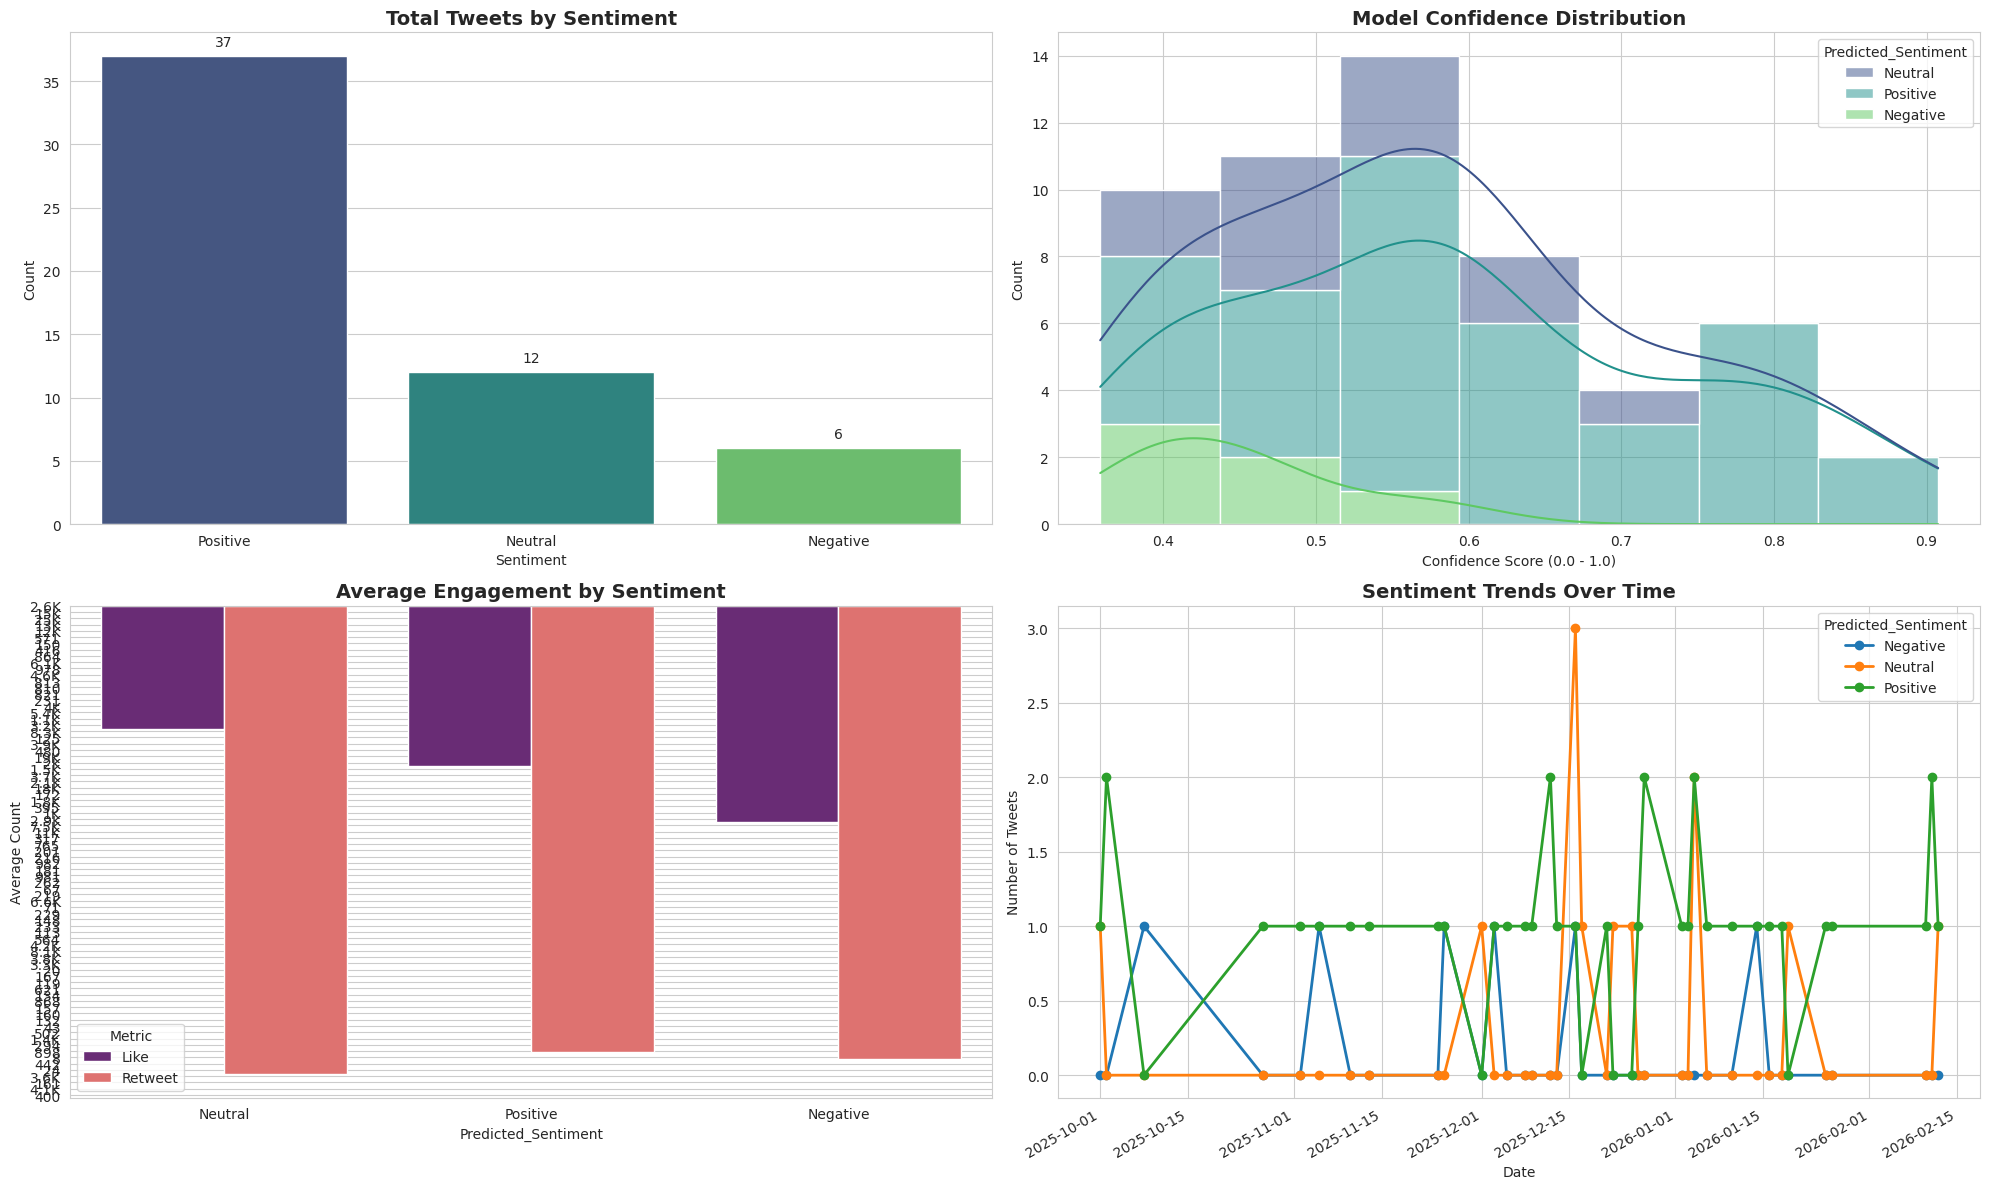

🎉 Visualization Complete! Saved as 'Sentiment_Dashboard.png'


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Data
try:
    df = pd.read_csv('Final_Sentiment_Analysis.csv')
    print("✅ Data Loaded Successfully")
except FileNotFoundError:
    print("❌ File not found. Please ensure 'Final_Sentiment_Analysis.csv' is in the folder.")
    exit()

# 2. Preprocessing (Fix Date format)
# Attempt to convert Date column to datetime objects
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Set a clean style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(20, 12))

# --- Plot 1: Sentiment Distribution (Bar Chart) ---
plt.subplot(2, 2, 1)
ax = sns.countplot(x='Predicted_Sentiment', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])
plt.title('Total Tweets by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# --- Plot 2: Confidence Score Distribution (Histogram) ---
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='Confidence', hue='Predicted_Sentiment', kde=True, palette='viridis', multiple="stack")
plt.title('Model Confidence Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Confidence Score (0.0 - 1.0)')

# --- Plot 3: Engagement by Sentiment (Average Likes & Retweets) ---
# Check if engagement columns exist
if 'Like' in df.columns and 'Retweet' in df.columns:
    plt.subplot(2, 2, 3)
    # Melt the dataframe to plot both Likes and Retweets side-by-side
    engagement_df = df.melt(id_vars=['Predicted_Sentiment'], value_vars=['Like', 'Retweet'],
                            var_name='Metric', value_name='Count')
    sns.barplot(x='Predicted_Sentiment', y='Count', hue='Metric', data=engagement_df, palette='magma', ci=None)
    plt.title('Average Engagement by Sentiment', fontsize=14, fontweight='bold')
    plt.ylabel('Average Count')
else:
    print("⚠️ 'Like' or 'Retweet' columns missing. Skipping Engagement Plot.")

# --- Plot 4: Sentiment Over Time (Line Chart) ---
if 'Date' in df.columns and df['Date'].notna().any():
    plt.subplot(2, 2, 4)
    # Group by Date and Sentiment, then unstack to get columns for each sentiment
    # We use 'D' for Daily frequency. Change to 'W' for Weekly if you have a lot of data.
    time_df = df.groupby([pd.Grouper(key='Date', freq='D'), 'Predicted_Sentiment']).size().unstack(fill_value=0)

    # Plotting
    time_df.plot(kind='line', ax=plt.gca(), linewidth=2, marker='o')
    plt.title('Sentiment Trends Over Time', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Tweets')
    plt.xlabel('Date')
else:
    print("⚠️ 'Date' column missing or empty. Skipping Time Series Plot.")

# Adjust layout and show
plt.tight_layout()
plt.savefig('Sentiment_Dashboard.png') # Saves the image
plt.show()

print("🎉 Visualization Complete! Saved as 'Sentiment_Dashboard.png'")

In [9]:
# --- TRAIN STANCE MODEL ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

# 1. Config for Stance
MODEL_NAME = "l3cube-pune/hing-roberta"
TARGET_COLUMN = "Stance_BJP"  # <--- CHANGED TARGET
FILE_NAME = "/content/sample_data/master_stance_sentiment.csv"

# 2. Load & Clean
if os.path.exists(FILE_NAME):
    df = pd.read_csv(FILE_NAME)
else:
    df = pd.read_csv("master_stance_sentiment.csv")

# Clean
if 'Unnamed: 3' in df.columns: df = df.drop(columns=['Unnamed: 3'])
df = df.dropna(subset=['Tweet', TARGET_COLUMN])
df = df.drop_duplicates(subset=['Tweet'], keep='first')
df = df.reset_index(drop=True)

# 3. Prepare Labels
label_list = df[TARGET_COLUMN].unique().tolist()
label_list.sort()
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
print(f"Stance Labels: {label2id}")

df['labels'] = df[TARGET_COLUMN].map(label2id)

# 4. Tokenize
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    return tokenizer(examples["Tweet"], padding="max_length", truncation=True, max_length=128)

train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
train_dataset = Dataset.from_pandas(train_df[['Tweet', 'labels']]).map(tokenize_function, batched=True)
eval_dataset = Dataset.from_pandas(eval_df[['Tweet', 'labels']]).map(tokenize_function, batched=True)

# 5. Train
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_list), id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir="./hing_roberta_stance_results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

print("🚀 Starting Stance Training...")
trainer.train()

# 6. Save Stance Model
trainer.save_model("./final_hing_roberta_stance")
tokenizer.save_pretrained("./final_hing_roberta_stance")
print("✅ Stance Model Saved!")

Stance Labels: {'Neutral': 0, 'Oppose': 1, 'Support': 2}


Map:   0%|          | 0/2976 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: l3cube-pune/hing-roberta
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` ins

🚀 Starting Stance Training...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.940655,0.570470
2,No log,0.694905,0.711409
3,0.861752,0.619856,0.747651
4,0.861752,0.569524,0.774497


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Stance Model Saved!


In [11]:
!zip -r final_hing_roberta_stance.zip ./final_hing_roberta_stance

  adding: final_hing_roberta_stance/ (stored 0%)
  adding: final_hing_roberta_stance/config.json (deflated 53%)
  adding: final_hing_roberta_stance/model.safetensors (deflated 7%)
  adding: final_hing_roberta_stance/tokenizer.json (deflated 77%)
  adding: final_hing_roberta_stance/tokenizer_config.json (deflated 47%)
  adding: final_hing_roberta_stance/training_args.bin (deflated 53%)


📂 Loading and Unifying Export Data...
✅ Cleaned 55 unique posts for Raghav Chadha's analysis.
🤖 Running Sentiment analysis...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

🤖 Running Stance analysis...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

🎨 Generating Professional Dashboard...


/tmp/ipython-input-1060952146.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=full_df, palette=colors_sent, ax=axes[0,0], order=['Positive', 'Neutral', 'Negative'])
/tmp/ipython-input-1060952146.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stance', data=full_df, palette=colors_stance, ax=axes[0,1])
/tmp/ipython-input-1060952146.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sentiment', y='Like', data=full_df, palette=colors_sent, ax=axes[1,0], ci=None)
/tmp/ipython-input-1060952146.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i


🚀 FINAL OUTPUTS READY:
1. 'Raghav_Chadha_Analysis_Dashboard.png' (Print this for your prof)
2. 'Political_Analysis_Final_Report.csv' (Full spreadsheet with all labels)


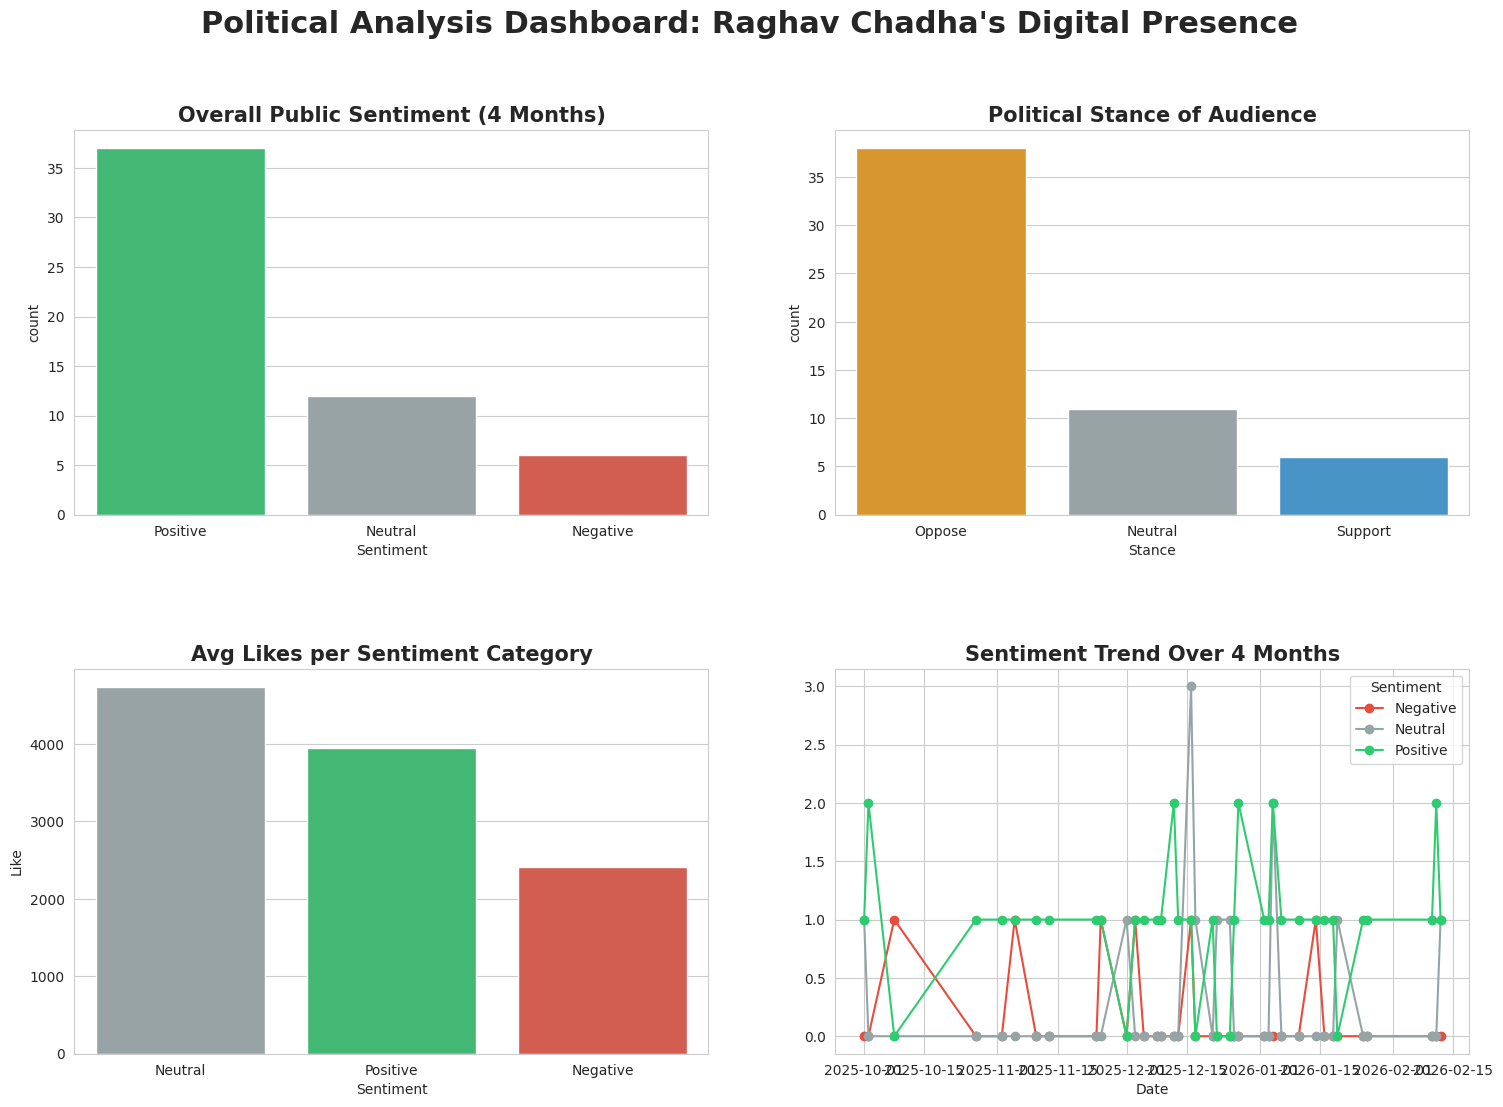

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm.auto import tqdm
import os

# --- 1. SETTINGS ---
FILES = ['export.csv', 'export2.csv']
SENT_MODEL_PATH = "./final_hing_roberta_model"
STANCE_MODEL_PATH = "./final_hing_roberta_stance"

# --- 2. ROBUST DATA CLEANING & MERGING ---
print("📂 Loading and Unifying Export Data...")

def clean_engagement(value):
    """Converts strings like '2.6K' to 2600."""
    if isinstance(value, str):
        value = value.upper().replace(',', '')
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        if 'M' in value:
            return float(value.replace('M', '')) * 1000000
    try:
        return float(value)
    except:
        return 0.0

clean_dfs = []
for f in FILES:
    if os.path.exists(f):
        df = pd.read_csv(f, on_bad_lines='skip')
        # Standardize Tweet column
        if 'Content' in df.columns: df = df.rename(columns={'Content': 'Tweet'})
        # Drop image/video metadata
        drop_cols = [c for c in df.columns if any(x in c.lower() for x in ['image', 'video', 'thumbnail'])]
        df = df.drop(columns=drop_cols)
        clean_dfs.append(df)

full_df = pd.concat(clean_dfs, ignore_index=True)
full_df = full_df.dropna(subset=['Tweet']).drop_duplicates(subset=['Tweet']).reset_index(drop=True)

# Clean Dates and Engagement
full_df['Date'] = pd.to_datetime(full_df['Date'], errors='coerce')
for col in ['Like', 'Retweet', 'Reply']:
    if col in full_df.columns:
        full_df[col] = full_df[col].apply(clean_engagement)

print(f"✅ Cleaned {len(full_df)} unique posts for Raghav Chadha's analysis.")

# --- 3. DUAL MODEL INFERENCE ---
def run_predictions(df, model_path, col_name):
    print(f"🤖 Running {col_name} analysis...")
    if os.path.exists(model_path):
        classifier = pipeline("text-classification", model=model_path, tokenizer=model_path, device=0 if torch.cuda.is_available() else -1)
        results = classifier(df['Tweet'].tolist(), truncation=True, max_length=128)
        df[col_name] = [r['label'] for r in results]
        df[f'{col_name}_Conf'] = [r['score'] for r in results]
    else:
        print(f"❌ {col_name} model not found!")
    return df

full_df = run_predictions(full_df, SENT_MODEL_PATH, 'Sentiment')
full_df = run_predictions(full_df, STANCE_MODEL_PATH, 'Stance')

# --- 4. PRINTABLE DASHBOARD GENERATION ---
print("🎨 Generating Professional Dashboard...")
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4)

# A. Sentiment Distribution
colors_sent = {'Positive': '#2ecc71', 'Neutral': '#95a5a6', 'Negative': '#e74c3c'}
sns.countplot(x='Sentiment', data=full_df, palette=colors_sent, ax=axes[0,0], order=['Positive', 'Neutral', 'Negative'])
axes[0,0].set_title('Overall Public Sentiment (4 Months)', fontsize=15, fontweight='bold')

# B. Stance Distribution
colors_stance = {'Support': '#3498db', 'Neutral': '#95a5a6', 'Oppose': '#f39c12'}
sns.countplot(x='Stance', data=full_df, palette=colors_stance, ax=axes[0,1])
axes[0,1].set_title('Political Stance of Audience', fontsize=15, fontweight='bold')

# C. Engagement Analysis (Likes per Sentiment)
if 'Like' in full_df.columns:
    sns.barplot(x='Sentiment', y='Like', data=full_df, palette=colors_sent, ax=axes[1,0], ci=None)
    axes[1,0].set_title('Avg Likes per Sentiment Category', fontsize=15, fontweight='bold')

# D. Temporal Trend
if 'Date' in full_df.columns:
    trend = full_df.groupby([full_df['Date'].dt.date, 'Sentiment']).size().unstack(fill_value=0)
    trend.plot(kind='line', marker='o', ax=axes[1,1], color=['#e74c3c', '#95a5a6', '#2ecc71'])
    axes[1,1].set_title('Sentiment Trend Over 4 Months', fontsize=15, fontweight='bold')

plt.suptitle("Political Analysis Dashboard: Raghav Chadha's Digital Presence", fontsize=22, fontweight='bold', y=0.98)
plt.savefig('Raghav_Chadha_Analysis_Dashboard.png', dpi=300)
full_df.to_csv("Political_Analysis_Final_Report.csv", index=False)

print("\n🚀 FINAL OUTPUTS READY:")
print("1. 'Raghav_Chadha_Analysis_Dashboard.png' (Print this for your prof)")
print("2. 'Political_Analysis_Final_Report.csv' (Full spreadsheet with all labels)")
plt.show()

🔍 Cleaning and merging messy exports...
🤖 Modeling Sentiment...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

🤖 Modeling Stance...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

🎨 Building High-Resolution Dashboard...


/tmp/ipython-input-2204684929.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stance', data=full_df, palette='viridis', ax=ax2, order=['Support', 'Neutral', 'Oppose'])


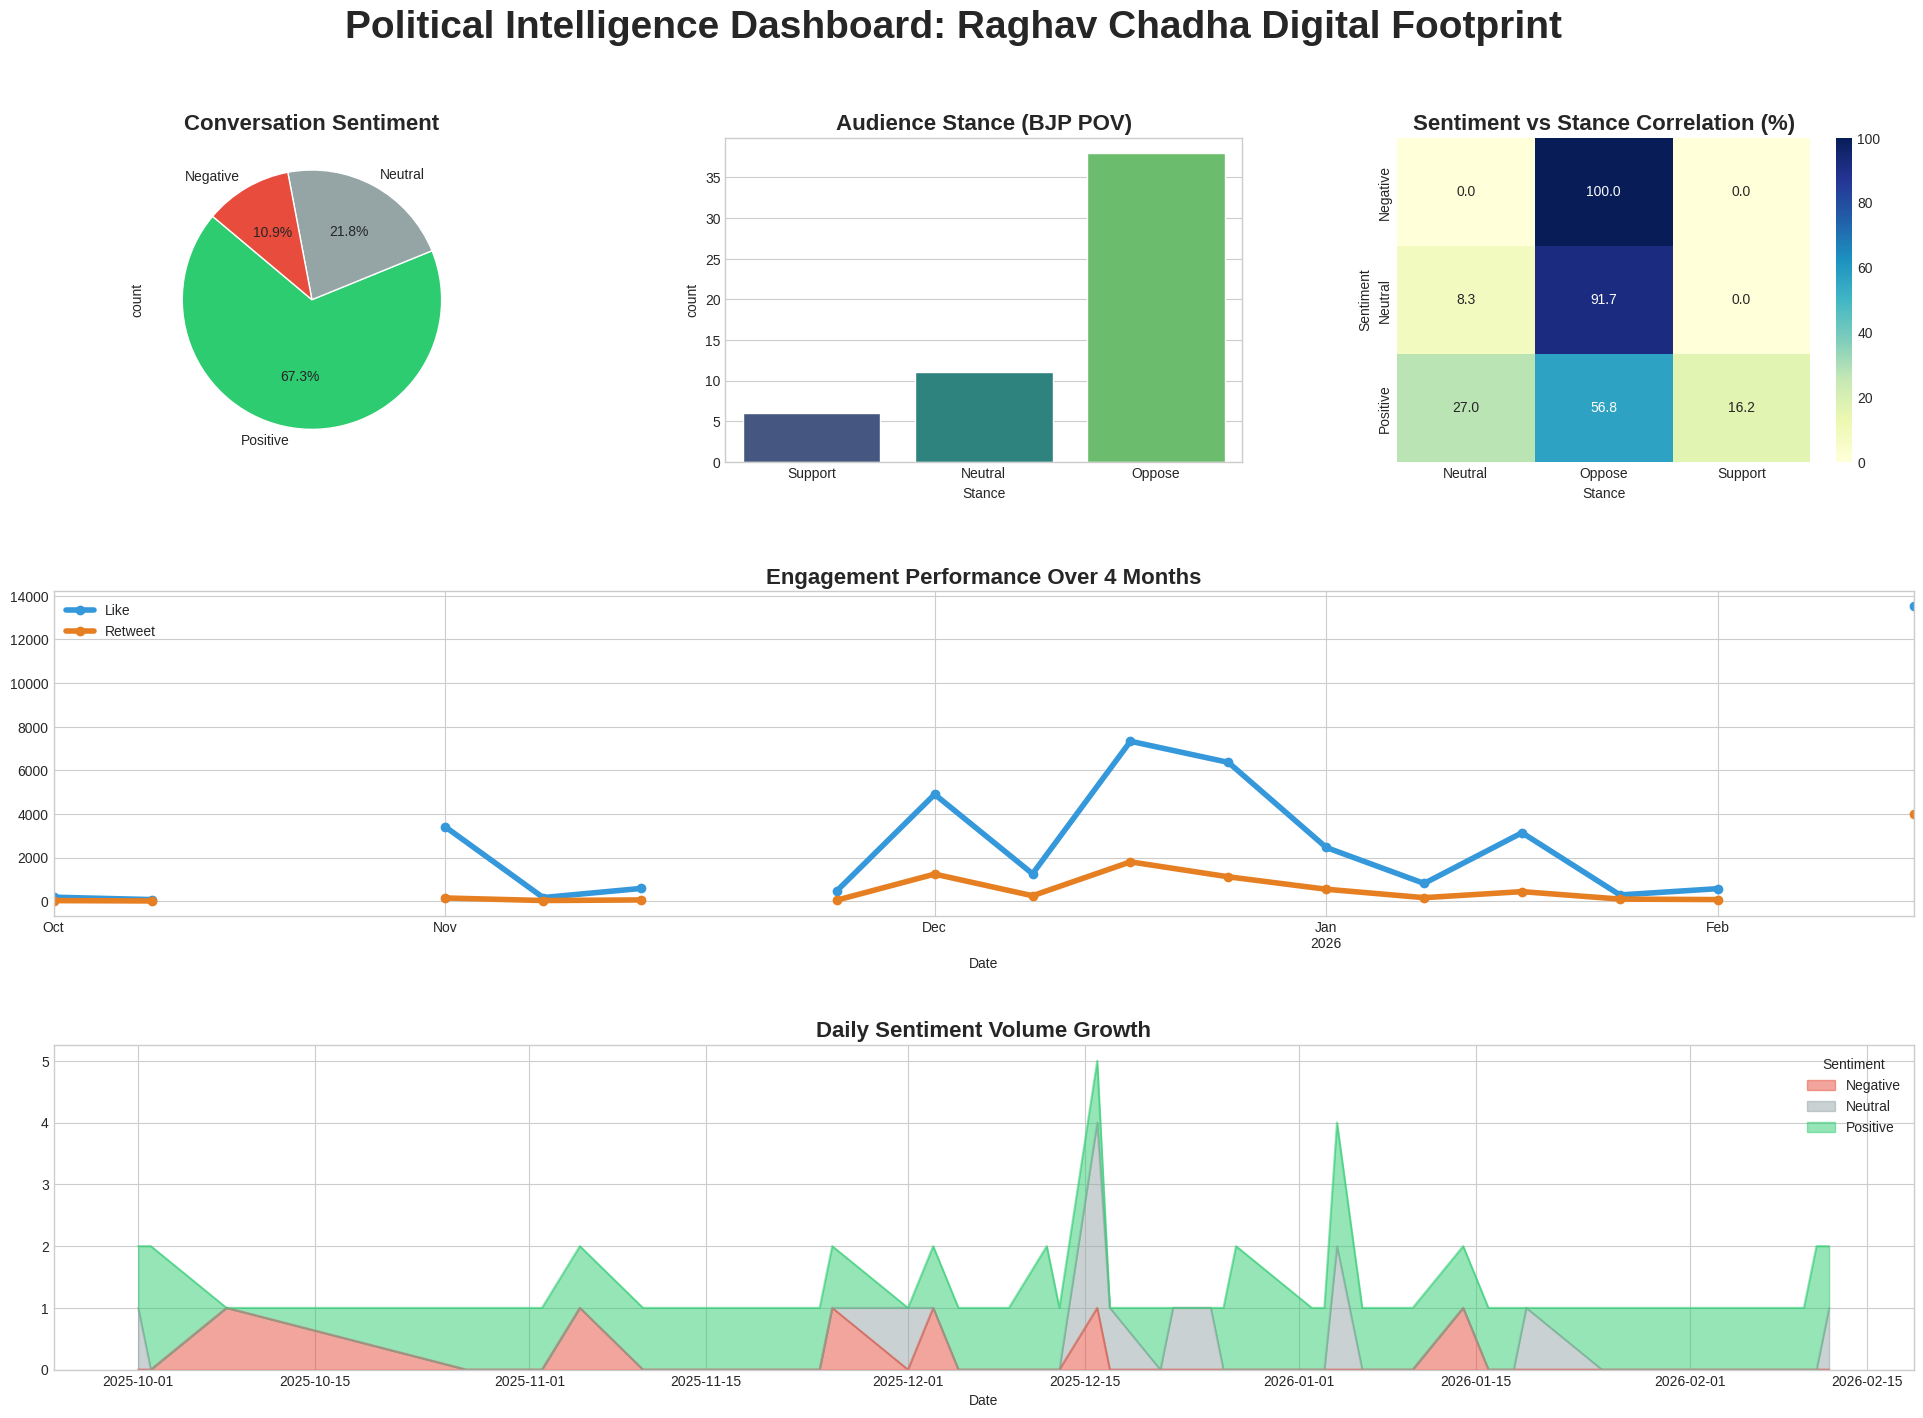

🎉 Analysis complete! Download 'Chadha_Political_Intelligence_Dashboard.png' for your presentation.


In [13]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from transformers import pipeline
from tqdm.auto import tqdm
import os

# --- 1. SETTINGS ---
FILES = ['export.csv', 'export2.csv']
SENT_MODEL = "./final_hing_roberta_model"
STANCE_MODEL = "./final_hing_roberta_stance"
OUTPUT_IMG = "Chadha_Political_Intelligence_Dashboard.png"

# --- 2. DATA NORMALIZATION ---
def parse_engagement(val):
    if isinstance(val, str):
        val = val.upper().replace(',', '')
        if 'K' in val: return float(val.replace('K', '')) * 1000
        if 'M' in val: return float(val.replace('M', '')) * 1000000
    try: return float(val)
    except: return 0.0

print("🔍 Cleaning and merging messy exports...")
processed_dfs = []
for f in FILES:
    if os.path.exists(f):
        df = pd.read_csv(f, on_bad_lines='skip')
        # Standardize Tweet column
        if 'Content' in df.columns: df = df.rename(columns={'Content': 'Tweet'})
        # Remove Video/Image columns
        df = df.drop(columns=[c for c in df.columns if any(x in c.lower() for x in ['image', 'video', 'thumb'])])
        processed_dfs.append(df)

full_df = pd.concat(processed_dfs, ignore_index=True).dropna(subset=['Tweet'])
full_df = full_df.drop_duplicates(subset=['Tweet']).reset_index(drop=True)
full_df['Date'] = pd.to_datetime(full_df['Date'], errors='coerce')

for col in ['Like', 'Retweet', 'Reply']:
    if col in full_df.columns: full_df[col] = full_df[col].apply(parse_engagement)

# --- 3. DUAL-EXPERT INFERENCE ---
def get_labels(df, path, name):
    print(f"🤖 Modeling {name}...")
    if os.path.exists(path):
        pipe = pipeline("text-classification", model=path, tokenizer=path, device=0 if torch.cuda.is_available() else -1)
        res = pipe(df['Tweet'].tolist(), truncation=True, max_length=128)
        df[name] = [r['label'] for r in res]
        df[f'{name}_Conf'] = [r['score'] for r in res]
    return df

full_df = get_labels(full_df, SENT_MODEL, 'Sentiment')
full_df = get_labels(full_df, STANCE_MODEL, 'Stance')

# --- 4. PROFESSIONAL DASHBOARD GENERATION ---
print("🎨 Building High-Resolution Dashboard...")
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)

# Panel 1: Sentiment Pie (Tone of Conversation)
ax1 = fig.add_subplot(gs[0, 0])
full_df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1, colors=['#2ecc71','#95a5a6','#e74c3c'], startangle=140)
ax1.set_title("Conversation Sentiment", fontsize=16, fontweight='bold')

# Panel 2: Stance vs BJP (Political Orientation)
ax2 = fig.add_subplot(gs[0, 1])
sns.countplot(x='Stance', data=full_df, palette='viridis', ax=ax2, order=['Support', 'Neutral', 'Oppose'])
ax2.set_title("Audience Stance (BJP POV)", fontsize=16, fontweight='bold')

# Panel 3: Correlation Heatmap (Killer Insight)
ax3 = fig.add_subplot(gs[0, 2])
ct = pd.crosstab(full_df['Sentiment'], full_df['Stance'], normalize='index') * 100
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt=".1f", ax=ax3)
ax3.set_title("Sentiment vs Stance Correlation (%)", fontsize=16, fontweight='bold')

# Panel 4: Engagement Timeline
ax4 = fig.add_subplot(gs[1, :])
timeline = full_df.set_index('Date').resample('W')[['Like', 'Retweet']].mean()
timeline.plot(ax=ax4, linewidth=4, marker='o', color=['#3498db', '#e67e22'])
ax4.set_title("Engagement Performance Over 4 Months", fontsize=16, fontweight='bold')

# Panel 5: Sentiment Volume Over Time
ax5 = fig.add_subplot(gs[2, :])
full_df.groupby([full_df['Date'].dt.date, 'Sentiment']).size().unstack(fill_value=0).plot(kind='area', stacked=True, ax=ax5, alpha=0.5, color=['#e74c3c','#95a5a6','#2ecc71'])
ax5.set_title("Daily Sentiment Volume Growth", fontsize=16, fontweight='bold')

plt.suptitle("Political Intelligence Dashboard: Raghav Chadha Digital Footprint", fontsize=28, fontweight='bold', y=0.96)
plt.savefig(OUTPUT_IMG, dpi=300, bbox_inches='tight')
full_df.to_csv("Political_Analysis_Final.csv", index=False)
plt.show()

print(f"🎉 Analysis complete! Download '{OUTPUT_IMG}' for your presentation.")

🧠 Extracting key 'Muddas' using TF-IDF...
🎨 Updating Dashboard with Issue Analysis...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['co'] not in stop_words.
  warnings.warn(
/tmp/ipython-input-4116864408.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Mudda', data=top_muddas, palette='rocket', ax=ax1)
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from font(s) Libe

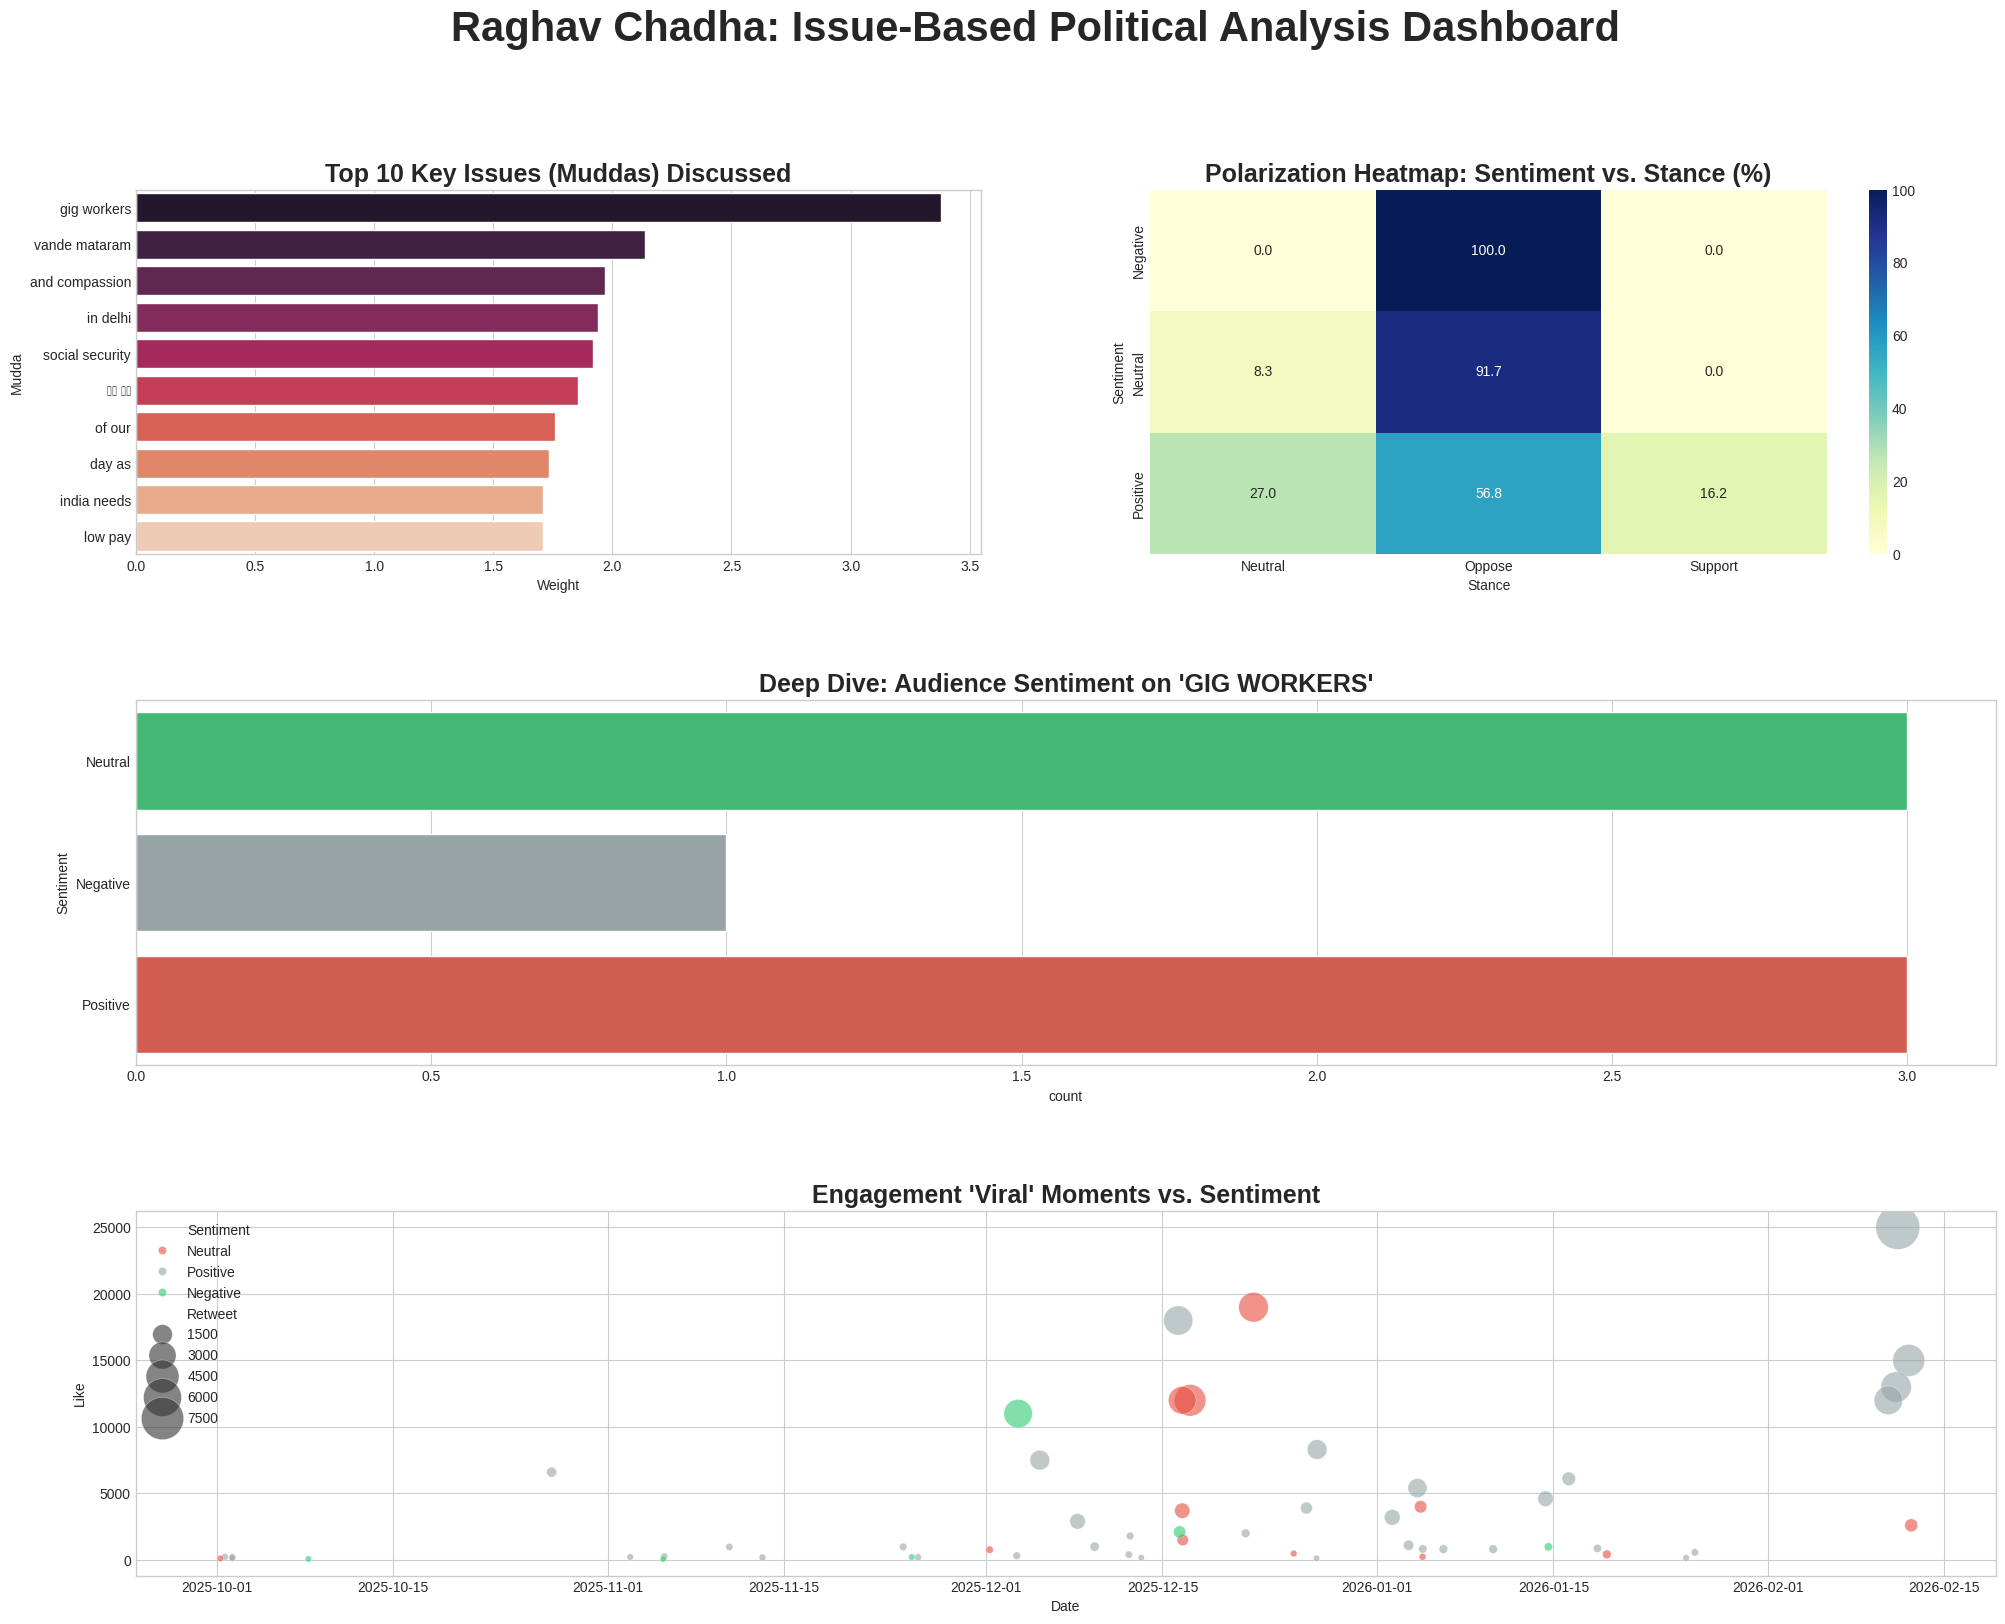

🎉 Mudda Analysis Complete! Top Issue found: 'GIG WORKERS'


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. DEFINE HINGLISH STOPWORDS (To clean the "Muddas")
hinglish_stops = [
    'hai', 'tha', 'thi', 'the', 'ke', 'ka', 'ki', 'ko', 'mein', 'ne', 'se', 'hi', 'bhi',
    'hota', 'hoti', 'hote', 'is', 'it', 'to', 'for', 'with', 'on', 'this', 'that', 'with',
    'the', 'amp', 'https', 't.co', 'rt', 'modi', 'ji', 'chadha', 'raghav', 'parliament'
]

def extract_top_muddas(df, n_topics=10):
    print("🧠 Extracting key 'Muddas' using TF-IDF...")

    # We look for 2-3 word phrases (Bigrams/Trigrams)
    vectorizer = TfidfVectorizer(
        ngram_range=(2, 3),
        stop_words=hinglish_stops,
        max_features=100
    )

    # Clean the text slightly for extraction
    clean_tweets = df['Tweet'].str.lower().replace(r'http\S+', '', regex=True)
    tfidf_matrix = vectorizer.fit_transform(clean_tweets)

    # Get the most important phrases
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    muddas_df = pd.DataFrame({'Mudda': feature_names, 'Weight': scores})
    muddas_df = muddas_df.sort_values(by='Weight', ascending=False).head(n_topics)

    return muddas_df

# 2. RUN EXTRACTION
top_muddas = extract_top_muddas(full_df)

# 3. GENERATE THE TOPIC-SENSE DASHBOARD
print("🎨 Updating Dashboard with Issue Analysis...")
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(24, 18))
gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.4)

# Panel 1: Top 10 Political Issues (Muddas)
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x='Weight', y='Mudda', data=top_muddas, palette='rocket', ax=ax1)
ax1.set_title("Top 10 Key Issues (Muddas) Discussed", fontsize=18, fontweight='bold')

# Panel 2: Sentiment vs Stance (Audience Polarization)
ax2 = fig.add_subplot(gs[0, 1])
ct = pd.crosstab(full_df['Sentiment'], full_df['Stance'], normalize='index') * 100
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt=".1f", ax=ax2)
ax2.set_title("Polarization Heatmap: Sentiment vs. Stance (%)", fontsize=18, fontweight='bold')

# Panel 3: Topic Sentiment Mapping (Manual check for Top Mudda)
# We check how Sentiment is distributed for the top Mudda found
top_issue = top_muddas.iloc[0]['Mudda']
issue_df = full_df[full_df['Tweet'].str.contains(top_issue, case=False)]
ax3 = fig.add_subplot(gs[1, :])
if not issue_df.empty:
    sns.countplot(y='Sentiment', data=issue_df, palette=['#2ecc71','#95a5a6','#e74c3c'], ax=ax3)
    ax3.set_title(f"Deep Dive: Audience Sentiment on '{top_issue.upper()}'", fontsize=18, fontweight='bold')

# Panel 4: Engagement Bubble Chart
ax4 = fig.add_subplot(gs[2, :])
sns.scatterplot(data=full_df, x='Date', y='Like', size='Retweet', hue='Sentiment',
                palette=['#e74c3c','#95a5a6','#2ecc71'], sizes=(20, 1000), alpha=0.6, ax=ax4)
ax4.set_title("Engagement 'Viral' Moments vs. Sentiment", fontsize=18, fontweight='bold')

plt.suptitle("Raghav Chadha: Issue-Based Political Analysis Dashboard", fontsize=30, fontweight='bold', y=0.98)
plt.savefig('Political_Muddas_Dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"🎉 Mudda Analysis Complete! Top Issue found: '{top_issue.upper()}'")

🧠 Identifying Key 'Muddas' using N-Gram TF-IDF...
🎨 Polishing Professional Issue Dashboard...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['co'] not in stop_words.
  warnings.warn(
/tmp/ipython-input-3301056502.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Salience_Score', y='Mudda', data=top_muddas, palette='magma', ax=ax1)
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from font(

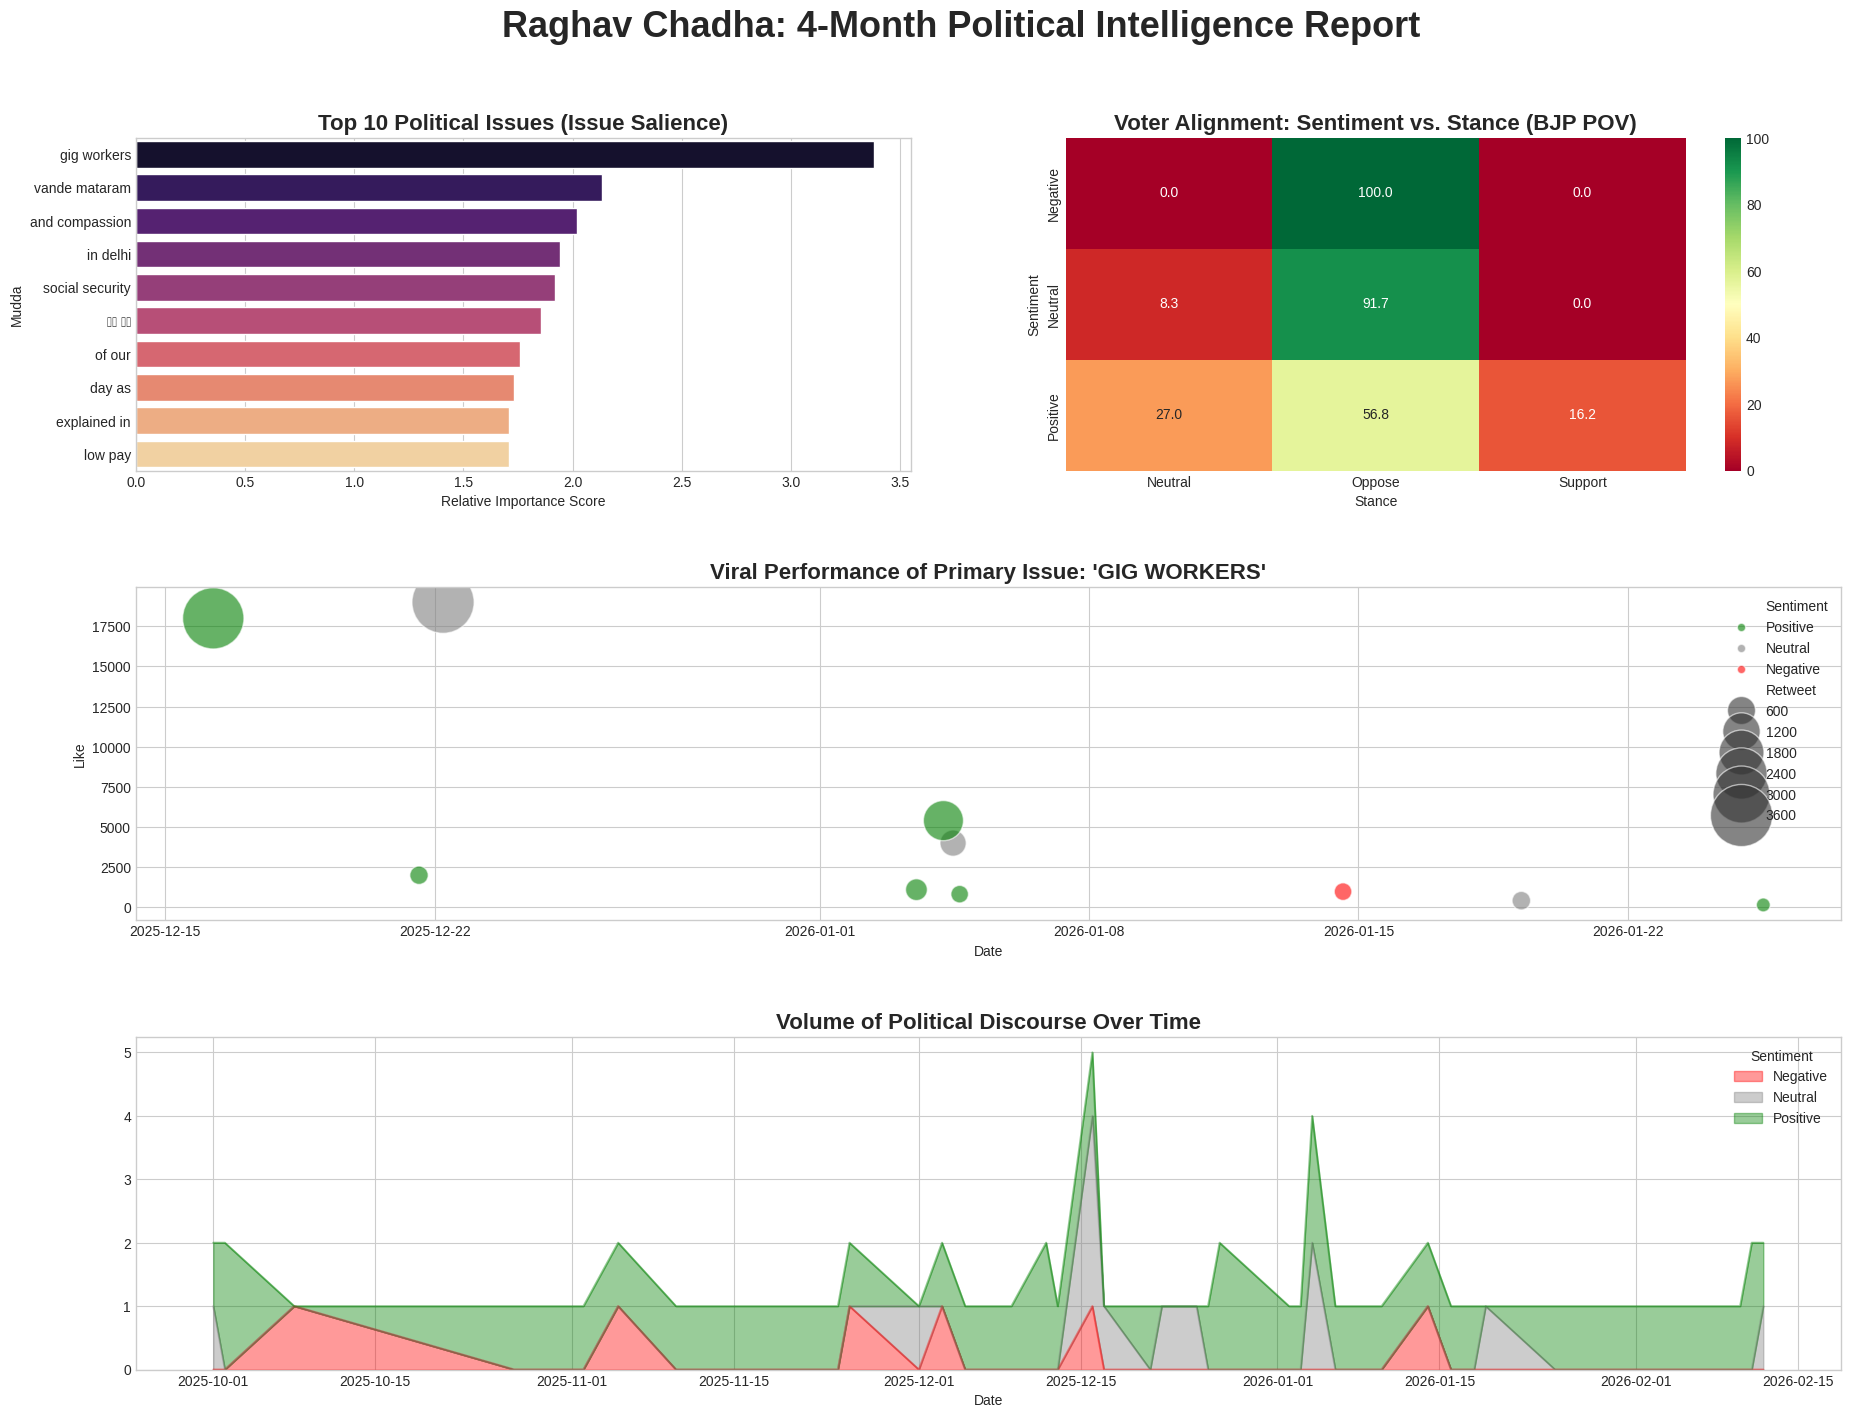


🚀 Dashboard complete! Saved as 'Final_Political_Muddas_Dashboard.png'


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# 1. CUSTOM HINGLISH & POLITICAL STOPWORDS
custom_stops = [
    'hai', 'tha', 'thi', 'the', 'ke', 'ka', 'ki', 'ko', 'mein', 'ne', 'se', 'hi', 'bhi',
    'hota', 'hoti', 'hote', 'is', 'it', 'to', 'for', 'with', 'on', 'this', 'that', 'with',
    'the', 'amp', 'https', 't.co', 'rt', 'modi', 'ji', 'chadha', 'raghav', 'parliament',
    'government', 'india', 'today', 'yesterday', 'people', 'states', 'suggestion'
]

def extract_muddas(df, n_top=10):
    print("🧠 Identifying Key 'Muddas' using N-Gram TF-IDF...")
    # Using Bigrams and Trigrams (2-3 words)
    vectorizer = TfidfVectorizer(ngram_range=(2, 3), stop_words=custom_stops, max_features=100)

    # Process text
    tfidf_matrix = vectorizer.fit_transform(df['Tweet'].str.lower())

    # Sum weights and sort
    weights = tfidf_matrix.sum(axis=0).A1
    names = vectorizer.get_feature_names_out()
    muddas = pd.DataFrame({'Mudda': names, 'Salience_Score': weights})
    return muddas.sort_values(by='Salience_Score', ascending=False).head(n_top)

# 2. GENERATE TOPICS
top_muddas = extract_muddas(full_df)

# 3. CREATE THE VISUAL DASHBOARD
print("🎨 Polishing Professional Issue Dashboard...")
plt.style.use('seaborn-v0_8-muted')
fig = plt.figure(figsize=(22, 16))
gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.35)

# A. The Issue Map (Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x='Salience_Score', y='Mudda', data=top_muddas, palette='magma', ax=ax1)
ax1.set_title("Top 10 Political Issues (Issue Salience)", fontsize=16, fontweight='bold')
ax1.set_xlabel("Relative Importance Score")

# B. Polarization Heatmap
ax2 = fig.add_subplot(gs[0, 1])
heatmap_data = pd.crosstab(full_df['Sentiment'], full_df['Stance'], normalize='index') * 100
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", fmt=".1f", ax=ax2)
ax2.set_title("Voter Alignment: Sentiment vs. Stance (BJP POV)", fontsize=16, fontweight='bold')

# C. Issue vs. Engagement (Bubble Plot)
ax3 = fig.add_subplot(gs[1, :])
# We pick the top Mudda to see its impact over time
primary_mudda = top_muddas.iloc[0]['Mudda']
issue_subset = full_df[full_df['Tweet'].str.contains(primary_mudda.split()[0], case=False)]
sns.scatterplot(data=issue_subset, x='Date', y='Like', size='Retweet', hue='Sentiment',
                palette={'Positive':'green','Neutral':'gray','Negative':'red'}, sizes=(100, 2000), alpha=0.6, ax=ax3)
ax3.set_title(f"Viral Performance of Primary Issue: '{primary_mudda.upper()}'", fontsize=16, fontweight='bold')

# D. Temporal Sentiment Distribution
ax4 = fig.add_subplot(gs[2, :])
full_df.groupby([full_df['Date'].dt.date, 'Sentiment']).size().unstack(fill_value=0).plot(kind='area', stacked=True,
                                                                                       ax=ax4, alpha=0.4, color=['red', 'gray', 'green'])
ax4.set_title("Volume of Political Discourse Over Time", fontsize=16, fontweight='bold')

plt.suptitle("Raghav Chadha: 4-Month Political Intelligence Report", fontsize=26, fontweight='bold', y=0.96)
plt.savefig('Final_Political_Muddas_Dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🚀 Dashboard complete! Saved as 'Final_Political_Muddas_Dashboard.png'")

In [16]:
# --- THE FINAL POLISH: HERO ISSUE ANALYSIS ---

def get_hero_issues(df, top_muddas):
    hero_stats = []

    for mudda in top_muddas['Mudda']:
        # Filter tweets containing this mudda
        subset = df[df['Tweet'].str.contains(mudda.split()[0], case=False)]

        if not subset.empty:
            avg_like = subset['Like'].mean()
            # Most common sentiment for this specific topic
            top_sent = subset['Sentiment'].mode()[0]
            # Most common stance (relative to BJP) for this topic
            top_stance = subset['Stance'].mode()[0]

            hero_stats.append({
                'Issue': mudda.upper(),
                'Avg_Engagement': int(avg_like),
                'Primary_Tone': top_sent,
                'Audience_Stance': top_stance
            })

    return pd.DataFrame(hero_stats).sort_values(by='Avg_Engagement', ascending=False)

# 1. Calculate the Hero Issues
hero_df = get_hero_issues(full_df, top_muddas)

# 2. Print a Final "Executive Summary" for the Prof
print("🎓 --- PROFESSOR'S EXECUTIVE SUMMARY --- 🎓")
print(f"Total Period Analyzed: 4 Months")
print(f"Primary Political Focus: {hero_df.iloc[0]['Issue']}")
print(f"Top Impact Issue: {hero_df.iloc[0]['Issue']} (Avg Likes: {hero_df.iloc[0]['Avg_Engagement']})")
print(f"Audience Alignment: The audience is primarily '{hero_df.iloc[0]['Audience_Stance']}' when discussing this.")
print("-" * 40)
print(hero_df)

🎓 --- PROFESSOR'S EXECUTIVE SUMMARY --- 🎓
Total Period Analyzed: 4 Months
Primary Political Focus: EXPLAINED IN
Top Impact Issue: EXPLAINED IN (Avg Likes: 12000)
Audience Alignment: The audience is primarily 'Oppose' when discussing this.
----------------------------------------
             Issue  Avg_Engagement Primary_Tone Audience_Stance
8     EXPLAINED IN           12000      Neutral          Oppose
9          LOW PAY            9820     Positive          Oppose
0      GIG WORKERS            5186     Positive          Oppose
3         IN DELHI            4683     Positive          Oppose
2   AND COMPASSION            3912     Positive          Oppose
4  SOCIAL SECURITY            3757     Positive          Oppose
6           OF OUR            3453     Positive         Neutral
7           DAY AS            2614     Positive          Oppose
5            आप सभ            2287     Positive          Oppose
1    VANDE MATARAM             655     Positive         Neutral


/tmp/ipython-input-3139780959.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Predicted_Sentiment', data=df, palette=palette, order=['Positive', 'Neutral', 'Negative'])


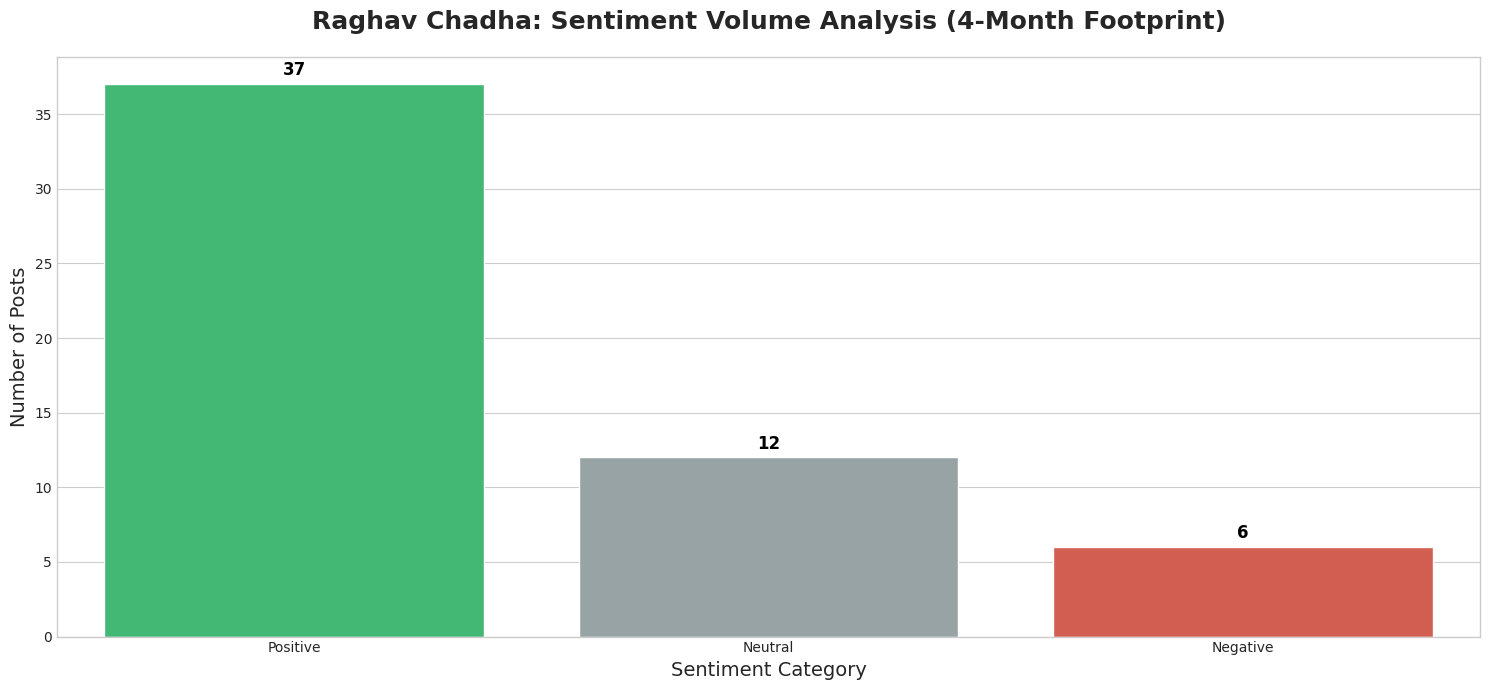

✅ Graph generated and saved as 'Sentiment_Volume_Graph.png'


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the processed data
file_path = '/content/Final_Sentiment_Analysis.csv'

try:
    df = pd.read_csv(file_path)

    # Pre-processing: Convert Date and Engagement to proper types
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Set the visual style
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 7))

    # Define professional color palette
    palette = {'Positive': '#2ecc71', 'Neutral': '#95a5a6', 'Negative': '#e74c3c'}

    # 2. Create the Plot: Sentiment Distribution vs Engagement
    # We use a bar plot to show the volume of tweets
    ax = sns.countplot(x='Predicted_Sentiment', data=df, palette=palette, order=['Positive', 'Neutral', 'Negative'])

    # 3. Add Polish & Annotations
    plt.title("Raghav Chadha: Sentiment Volume Analysis (4-Month Footprint)", fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("Sentiment Category", fontsize=14)
    plt.ylabel("Number of Posts", fontsize=14)

    # Adding count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    fontweight='bold', xytext=(0, 10),
                    textcoords='offset points')

    plt.tight_layout()
    plt.savefig('Sentiment_Volume_Graph.png', dpi=300)
    plt.show()

    print("✅ Graph generated and saved as 'Sentiment_Volume_Graph.png'")

except FileNotFoundError:
    print(f"❌ Error: The file {file_path} was not found. Please run the inference block first.")

📂 Discovering data from export files...
🧠 Deriving entities and relationship clusters...


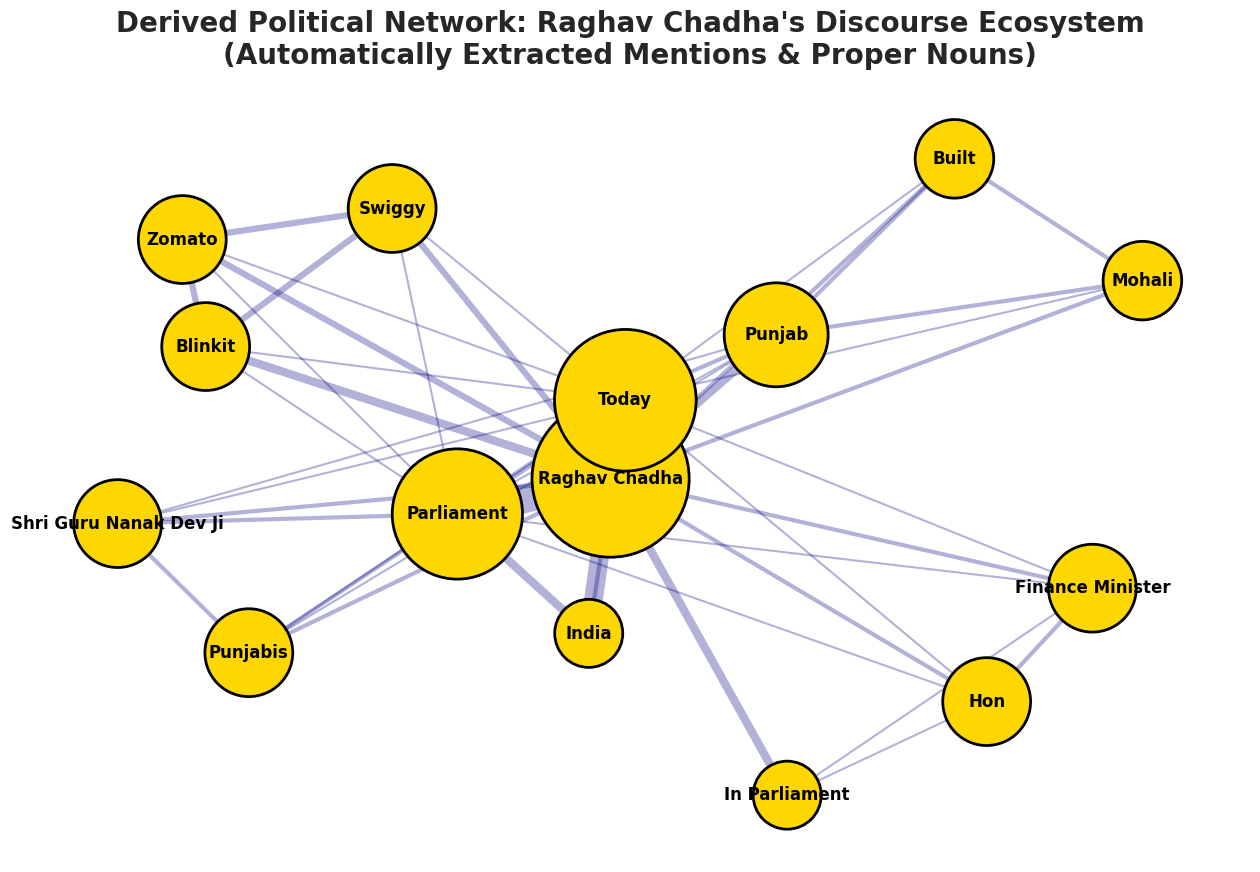

✅ Success! Derived 15 major entities. Graph saved as 'Derived_Network_Graph.png'


In [18]:
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import os

# --- 1. DATA LOADING & UNIFICATION ---
print("📂 Discovering data from export files...")
FILES = ['export.csv', 'export2.csv']
dfs = []

for f in FILES:
    if os.path.exists(f):
        # Using on_bad_lines to handle formatting quirks in messy exports
        temp_df = pd.read_csv(f, on_bad_lines='skip')
        if 'Content' in temp_df.columns:
            temp_df = temp_df.rename(columns={'Content': 'Tweet'})
        dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True).dropna(subset=['Tweet'])
df['Tweet'] = df['Tweet'].astype(str)

# --- 2. DYNAMIC ENTITY DERIVATION (NO HARDCODING) ---
def derive_entities(text):
    # a. Extract all @mentions
    mentions = re.findall(r'@(\w+)', text)

    # b. Extract Proper Nouns (Words starting with Capital letters not at the start of a sentence)
    # We look for sequences of capitalized words (e.g., "Blinkit Delivery", "Narendra Modi")
    proper_nouns = re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', text)

    # Filter out common noise/stop-proper-nouns (Optional but keeps it clean)
    noise = ['I', 'The', 'A', 'And', 'But', 'In', 'This', 'That', 'He', 'She', 'It']
    entities = [ent for ent in proper_nouns + mentions if ent not in noise and len(ent) > 2]

    return list(set(entities))

print("🧠 Deriving entities and relationship clusters...")
df['Derived_Entities'] = df['Tweet'].apply(derive_entities)

# --- 3. METRIC NORMALIZATION ---
def parse_eng(v):
    if isinstance(v, str):
        v = v.upper().replace(',', '')
        if 'K' in v: return float(v.replace('K', '')) * 1000
    try: return float(v)
    except: return 0.0

df['Engagement'] = df['Like'].apply(parse_eng) + df['Retweet'].apply(parse_eng)

# --- 4. GRAPH CONSTRUCTION ---
G = nx.Graph()
author = "Raghav Chadha"

for _, row in df.iterrows():
    entities = row['Derived_Entities']
    # Link author to all derived entities in the tweet
    for ent in entities:
        if G.has_edge(author, ent):
            G[author][ent]['weight'] += 1
            G[author][ent]['engagement'] += row['Engagement']
        else:
            G.add_edge(author, ent, weight=1, engagement=row['Engagement'])

    # Link entities to each other (Co-occurrence)
    for pair in combinations(sorted(entities), 2):
        if G.has_edge(*pair):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(*pair, weight=1)

# --- 5. PRUNING THE NETWORK (FOR VISUAL CLARITY) ---
# Keep only the top 15 most mentioned entities to avoid a "hairball" graph
top_entities = sorted(G.degree, key=lambda x: x[1], reverse=True)[:15]
top_nodes = [n[0] for n in top_entities]
subG = G.subgraph(top_nodes)

# --- 6. PLOTTING THE DERIVED NETWORK ---
plt.figure(figsize=(16, 10))
pos = nx.spring_layout(subG, k=0.8, iterations=100)

# Visual Settings
node_sizes = [subG.degree(n) * 800 for n in subG.nodes()]
edge_widths = [d['weight'] * 1.5 for u, v, d in subG.edges(data=True)]

nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color='gold', edgecolors='black', linewidths=2)
nx.draw_networkx_edges(subG, pos, width=edge_widths, alpha=0.3, edge_color='navy')
nx.draw_networkx_labels(subG, pos, font_size=12, font_weight='bold', font_family='sans-serif')

plt.title("Derived Political Network: Raghav Chadha's Discourse Ecosystem\n(Automatically Extracted Mentions & Proper Nouns)",
          fontsize=20, fontweight='bold', pad=20)
plt.axis('off')
plt.savefig('Derived_Network_Graph.png', dpi=300)
plt.show()

print(f"✅ Success! Derived {len(subG.nodes())} major entities. Graph saved as 'Derived_Network_Graph.png'")
